In [ ]:
import cv2
import numpy as np
import os
import scipy.io as sio
import glob

# Set the video source path to the training video directory
video_source_path = r'C:\Users\PREDATOR\Downloads\Avenue_Dataset\Avenue Dataset\training_videos'  # Adjust this to your dataset path
output_dir = 'processed_mat_files'  # Directory where .mat files will be saved
img_size = (160, 120)  # Image size to match the .mat file example

# Function to create a directory if it doesn't exist
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Function to extract and preprocess frames from a video, then return them as a NumPy array
def extract_and_preprocess_frames(video_path, img_size=(120, 160), frame_skip=2):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None
    
    frames = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Check if we need to keep this frame
        if frame_count % (frame_skip * cap.get(cv2.CAP_PROP_FPS)) == 0:
            # Resize the frame to the desired size
            frame = cv2.resize(frame, img_size)
            
            # Convert the frame to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Append the preprocessed frame to the list
            frames.append(gray_frame)

        frame_count += 1
    
    cap.release()
    
    if len(frames) == 0:
        print(f"No frames were extracted from {video_path}.")
        return None
    
    # Convert the list of frames into a NumPy array and reshape it to match the required dimensions
    frames_array = np.stack(frames, axis=2)
    return frames_array

# Process each video and save as a separate .mat file
def process_all_videos(video_source_path, output_dir, img_size=(120, 160)):
    create_dir(output_dir)  # Ensure output directory exists
    videos = sorted(glob.glob(video_source_path + '/*.avi'))  # Match .avi files

    for video in videos:
        video_name = os.path.splitext(os.path.basename(video))[0]
        print(f"Processing {video_name}")

        # Extract and preprocess frames
        video_frames = extract_and_preprocess_frames(video, img_size)
        
        if video_frames is None:
            print(f"Skipping {video_name} due to no frames processed.")
            continue
        
        # Save the processed frames to a .mat file
        output_file = os.path.join(output_dir, f'{video_name}.mat')
        sio.savemat(output_file, {'vol': video_frames})

        print(f"Saved {output_file}")

# Run the preprocessing
process_all_videos(video_source_path, output_dir, img_size)

print(f"Finished processing. All files are saved in {output_dir}.")

In [ ]:
import cv2
import numpy as np
import glob
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler

def load_data_from_mat(data_dir):
    videos = sorted(glob.glob(data_dir + '/*.mat'))
    data = []

    for video in videos:
        mat_data = sio.loadmat(video)
        frames = mat_data['vol']
        data.append(frames)

    return data

def preprocess_data(data, frame_count=10, target_size=(227, 227)):
    processed_data = []
    
    for video in data:
        if video.size == 0:
            print("Empty video data encountered.")
            continue
        
        video_frames = []
        num_frames = video.shape[2]
        
        if num_frames < frame_count:
            # Pad frames to make up for the lack of frames
            padding = frame_count - num_frames
            video = np.pad(video, ((0, 0), (0, 0), (0, padding)), mode='edge')
            num_frames = video.shape[2]
        
        for i in range(0, num_frames - frame_count + 1, frame_count):
            frames = video[:, :, i:i + frame_count]
            if frames.shape[2] != frame_count:
                print(f"Skipping frames due to shape mismatch: {frames.shape}")
                continue
            
            frames_resized = []
            for frame in frames.transpose(2, 0, 1):
                if frame.size == 0:
                    print("Empty frame encountered.")
                    continue
                resized_frame = cv2.resize(frame, target_size)
                frames_resized.append(resized_frame)
            
            if len(frames_resized) != frame_count:
                print(f"Frame count mismatch after resizing: {len(frames_resized)}")
                continue
            
            video_frames.append(np.stack(frames_resized, axis=2))
        
        if len(video_frames) == 0:
            print("No valid frames found for video.")
            continue
        
        video_frames_array = np.array(video_frames)
        if video_frames_array.ndim != 4:
            print(f"Unexpected shape for video frames array: {video_frames_array.shape}")
            continue
        
        processed_data.append(video_frames_array)

    if len(processed_data) == 0:
        raise ValueError("Processed data is empty.")
    
    processed_data = np.concatenate(processed_data, axis=0)
    processed_data = np.expand_dims(processed_data, axis=-1)  # Add channel dimension
    
    # Normalize data
    scaler = MinMaxScaler()
    processed_data = processed_data.astype('float32')
    processed_data = scaler.fit_transform(processed_data.reshape(-1, processed_data.shape[-1])).reshape(processed_data.shape)
    
    return processed_data

# Example usage:
data_dir = 'processed_mat_files'
video_data = load_data_from_mat(data_dir)
X_train = preprocess_data(video_data)
Y_train = X_train.copy()


In [ ]:
# Define the Spatiotemporal Autoencoder model
def load_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv3D(filters=128, kernel_size=(11, 11, 1), strides=(4, 4, 1), padding='valid', input_shape=input_shape, activation='tanh'))
    model.add(layers.Conv3D(filters=64, kernel_size=(5, 5, 1), strides=(2, 2, 1), padding='valid', activation='tanh'))
    
    model.add(layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', dropout=0.4, recurrent_dropout=0.3, return_sequences=True))
    model.add(layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', dropout=0.3, return_sequences=True))
    model.add(layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=1, return_sequences=True, padding='same', dropout=0.5))
    
    model.add(layers.Conv3DTranspose(filters=128, kernel_size=(5, 5, 1), strides=(2, 2, 1), padding='valid', activation='tanh'))
    model.add(layers.Conv3DTranspose(filters=1, kernel_size=(11, 11, 1), strides=(4, 4, 1), padding='valid', activation='tanh'))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

In [ ]:
# Define input shape for the model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])

# Initialize and train the model
model = load_model(input_shape)

callback_save = ModelCheckpoint("AnomalyDetector.keras", monitor="loss", save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='loss', patience=3)

print('Training the model...')
model.fit(X_train, Y_train, 
          batch_size=1, 
          epochs=200, 
          validation_split=0.1,  # Optional: Split data into training and validation sets
          callbacks=[callback_save, callback_early_stopping])

print('Training complete. Model saved as AnomalyDetector.keras.')

In [1]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('AnomalyDetector.keras')


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_test_video(video_path, img_size=(227, 227), frame_skip=2):
    """
    Extract and preprocess frames from a video.

    Args:
        video_path (str): Path to the video file.
        img_size (tuple): Desired image size (height, width).
        frame_skip (int): Number of frames to skip.

    Returns:
        np.ndarray: Preprocessed frames as a NumPy array.
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None
    
    frames = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Check if we need to keep this frame
        if frame_count % (frame_skip * cap.get(cv2.CAP_PROP_FPS)) == 0:
            # Resize the frame to the desired size
            frame = cv2.resize(frame, img_size)
            
            # Convert the frame to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Append the preprocessed frame to the list
            frames.append(gray_frame)

        frame_count += 1
    
    cap.release()
    
    if len(frames) == 0:
        print(f"No frames were extracted from {video_path}.")
        return None
    
    return np.array(frames)

def prepare_frames_for_model(frames, img_size=(227, 227), num_frames=10):
    """
    Prepare frames for model input.

    Args:
        frames (np.ndarray): Array of video frames.
        img_size (tuple): Desired image size (height, width).
        num_frames (int): Number of frames per input sequence.

    Returns:
        np.ndarray: Reshaped frames for model input.
    """
    frames_resized = [cv2.resize(frame, img_size) for frame in frames]
    
    # Make the number of frames divisible by num_frames
    total_frames = len(frames_resized)
    frames_resized = frames_resized[:total_frames - (total_frames % num_frames)]
    
    # Reshape frames to match model input shape
    frames_array = np.array(frames_resized)
    frames_array = frames_array.reshape(-1, img_size[0], img_size[1], num_frames, 1)
    
    return frames_array


In [6]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('AnomalyDetector.keras')

# Define paths
test_video_path = r'C:\Users\PREDATOR\Desktop\Case Study 2\testing_videos\05.avi'

# Preprocess and prepare test video frames
test_video_frames = preprocess_test_video(test_video_path)
test_frames_prepared = prepare_frames_for_model(test_video_frames)

# Predict and calculate reconstruction errors
predicted_frames = model.predict(test_frames_prepared)
reconstruction_error = np.mean(np.abs(test_frames_prepared - predicted_frames), axis=(1, 2, 3, 4))

# Identify frames with high reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # Adjust threshold as needed
anomaly_indices = np.where(reconstruction_error > threshold)[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


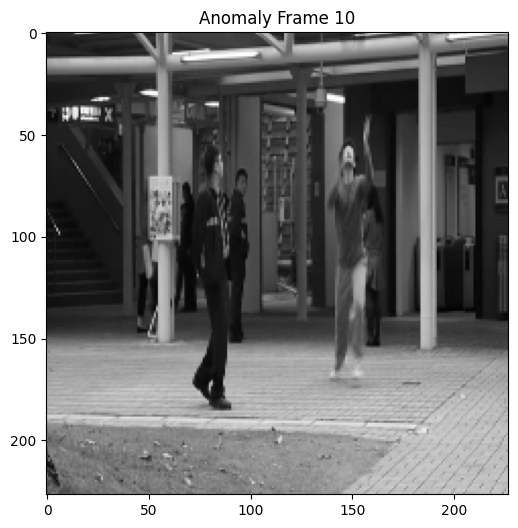

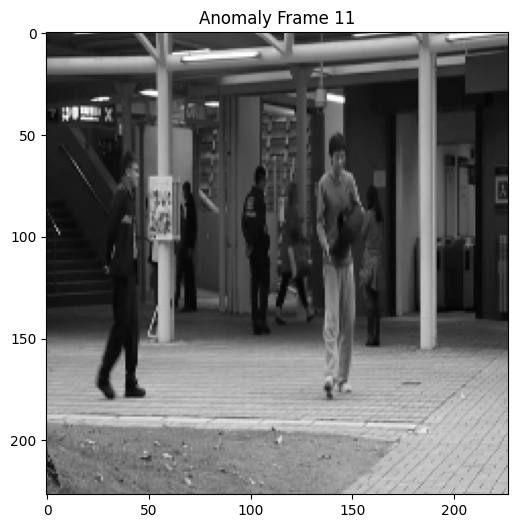

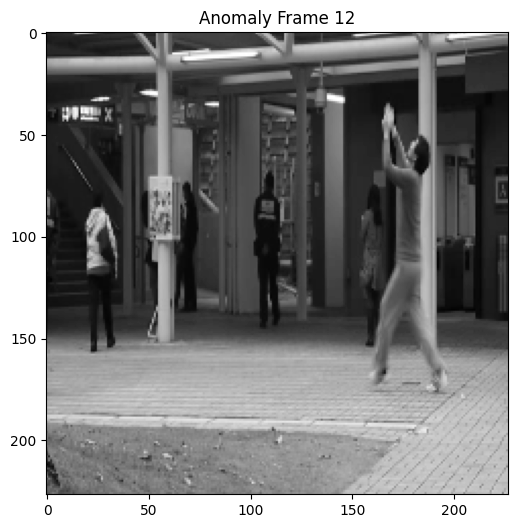

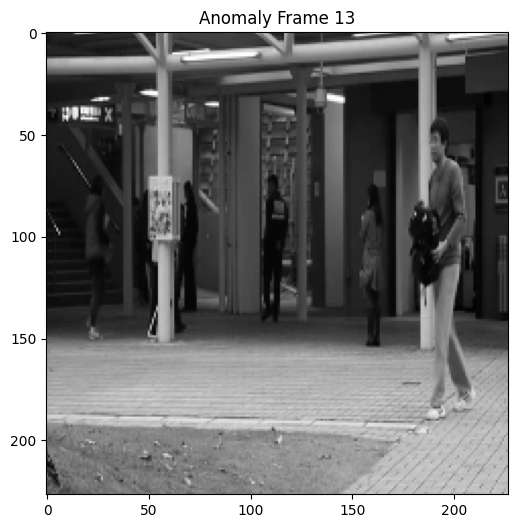

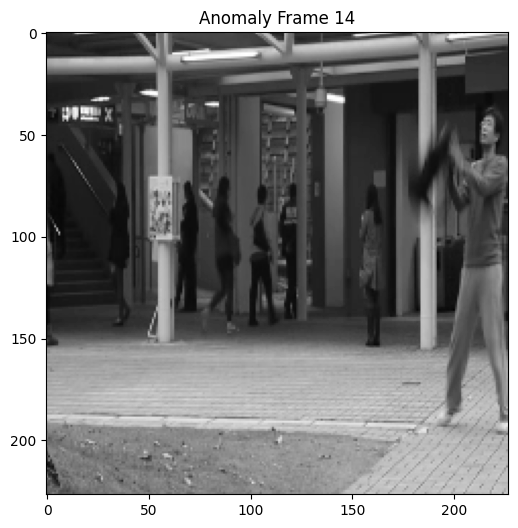

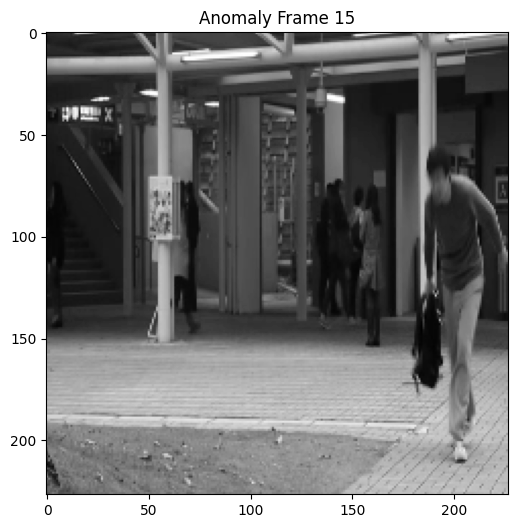

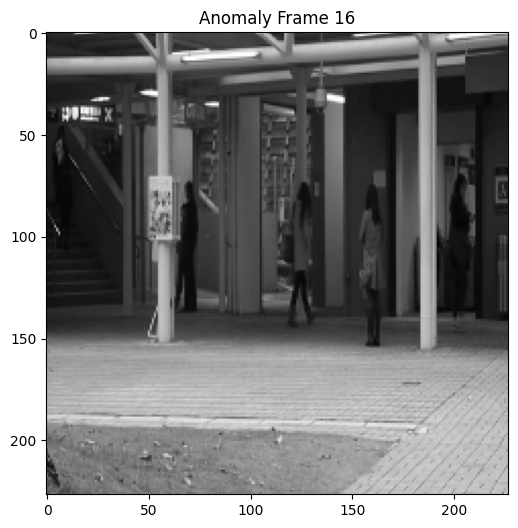

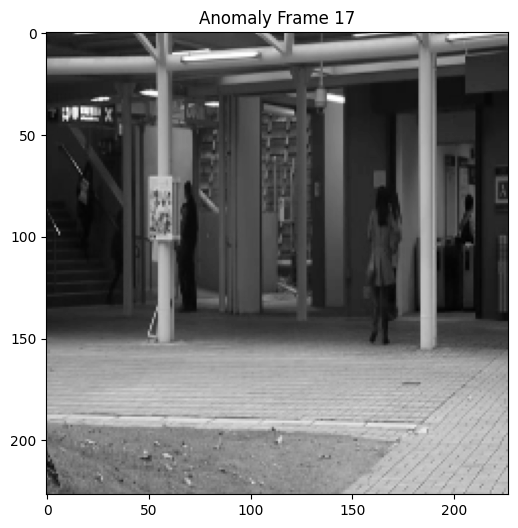

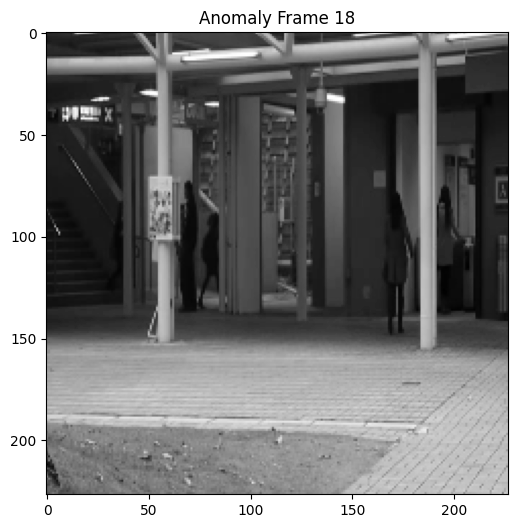

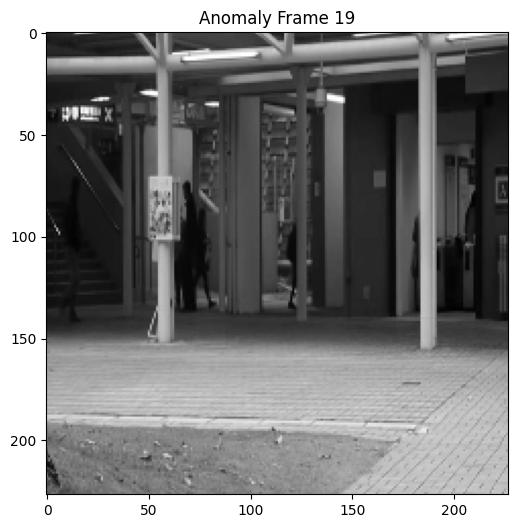

In [7]:
def display_frames(frames, indices, num_frames):
    """
    Display frames with anomalies.

    Args:
        frames (np.ndarray): Array of video frames.
        indices (np.ndarray): Indices of frames with anomalies.
        num_frames (int): Number of frames per sequence.
    """
    for i in indices:
        start = i * num_frames
        end = start + num_frames
        for j in range(start, end):
            plt.figure(figsize=(10, 6))
            plt.imshow(frames[j], cmap='gray')
            plt.title(f'Anomaly Frame {j}')
            plt.show()

# Display anomalous frames
num_frames = 10
display_frames(test_video_frames, anomaly_indices, num_frames)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


def preprocess_video(video_path, img_size=(227, 227), frame_skip=2):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize and convert to grayscale
        frame = cv2.resize(frame, img_size)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()
    return np.array(frames)

def prepare_frames_for_model(frames, img_size=(227, 227), num_frames=10):
    frames_resized = [cv2.resize(frame, img_size) for frame in frames]
    
    # Make the number of frames divisible by num_frames
    total_frames = len(frames_resized)
    frames_resized = frames_resized[:total_frames - (total_frames % num_frames)]
    
    # Reshape frames to match model input shape
    frames_array = np.array(frames_resized)
    frames_array = frames_array.reshape(-1, img_size[0], img_size[1], num_frames, 1)
    
    return frames_array

def detect_anomalies(model, frames, img_size=(227, 227), num_frames=10):
    prepared_frames = prepare_frames_for_model(frames, img_size, num_frames)
    predicted_frames = model.predict(prepared_frames)
    reconstruction_error = np.mean(np.abs(prepared_frames - predicted_frames), axis=(1, 2, 3, 4))
    
    threshold = np.percentile(reconstruction_error, 95)  # Adjust threshold as needed
    anomaly_indices = np.where(reconstruction_error > threshold)[0]
    
    return anomaly_indices


In [8]:
def display_video_with_anomalies(video_path, model, anomaly_indices, img_size=(227, 227), num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    anomaly_set = set(anomaly_indices)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize and convert to grayscale
        frame_resized = cv2.resize(frame, img_size)
        frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
        
        # Determine the index of the current frame within the video sequence
        current_sequence_index = frame_count // num_frames
        
        # Determine if the current frame is anomalous
        if current_sequence_index in anomaly_set:
            label = "Anomaly"
            color = (0, 0, 255)  # Red
        else:
            label = "Normal"
            color = (0, 255, 0)  # Green
        
        # Add text label to the frame
        cv2.putText(frame, label, (frame.shape[1] - 100, frame.shape[0] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        # Display the frame
        cv2.imshow('Video', frame)
        
        # Exit on 'q' key press
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        
        frame_count += 1
    
    cap.release()
    cv2.destroyAllWindows()

# Paths and setup
video_path = r'C:\Users\PREDATOR\Downloads\Avenue_Dataset\Avenue Dataset\testing_videos\05.avi'
model = load_model('AnomalyDetector.keras')

# Preprocess and detect anomalies
frames = preprocess_video(video_path)
anomaly_indices = detect_anomalies(model, frames)

# Display video with anomalies
display_video_with_anomalies(video_path, model, anomaly_indices)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step
